In [98]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams['savefig.bbox'] = 'tight'  # 保存图片时布局紧凑

def show_image(images, title=None):
    """
    显示图片
    """
    if not isinstance(images, list):
        images = [images]
    # figure 表示整个图形，axes 表示包含每个子图坐标轴的数组，squeeze=False 表示始终返回一个二维数组
    figure, axes = plt.subplots(ncols=len(images), squeeze=False)
    
    # 显示图片
    for i, image in enumerate(images):
        image = image.detach()
        image = F.to_pil_image(image)
        axes[0, i].imshow(np.asarray(image))
        axes[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # 设置标题
    if title:
        figure.suptitle(title)

In [99]:
import torchvision.transforms.functional as F
import torchvision.transforms

def resize_and_center_crop(image, size=520):
    """
    调整图片大小并裁剪中心区域
    """
    image = F.resize(image, size)
    image = F.center_crop(image, size)
    return image

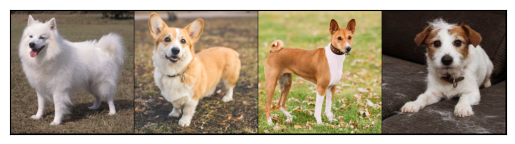

In [100]:
import os
from torchvision.utils import make_grid
from torchvision.io import read_image

# 读取图片
image_path = '../datas/_TutorialImages/Segmentation'
display_images = []
for filename in os.listdir(image_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        path = os.path.join(image_path, filename)
        # 读取图片
        _image = read_image(path)
        # 调整图片大小并裁剪中心区域
        _image = resize_and_center_crop(_image)
        display_images.append(_image)

# 显示图片
grid_image = make_grid(display_images)
show_image(grid_image)

In [101]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# 加载预训练模型
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights, progress=False)
model.eval()

# 预处理图片
transform = weights.transforms()
batch = torch.stack([transform(image) for image in display_images])

# 推理
with torch.no_grad():
    output = model(batch)['out']

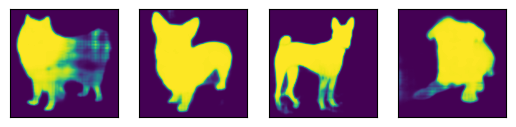

In [102]:
segmentation_class_to_idx = {cls: idx for idx, cls in enumerate(weights.meta['categories'])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

image_masks = [
    normalized_masks[image_idx, segmentation_class_to_idx['dog']]
    for image_idx in range(len(display_images))
]

show_image(image_masks)

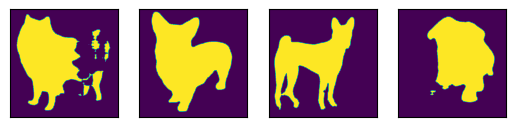

In [103]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == segmentation_class_to_idx['dog'])
show_image([m.float() for m in boolean_dog_masks])

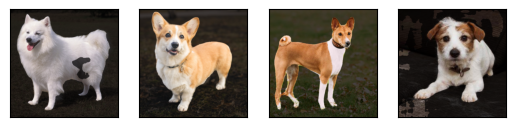

In [104]:
from torchvision.utils import draw_segmentation_masks

class_dim = 1
num_classes = len(weights.meta['categories'])
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(class_dim)[:, None, None, None]

all_classes_masks = all_classes_masks.swapaxes(0, 1)
dog_with_masks = [
    draw_segmentation_masks(image, mask, alpha=0.7)
    for image, mask in zip(display_images, all_classes_masks)
]
show_image(dog_with_masks)